In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from inpainting.dataset import Data, ResizeTransform, NoiseSampler
from gan.gan import Generator5Net, Discriminator5
from gan.trainer import GanTrainer
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import pandas as pd
from inpainting.visualize import plot_batch
from inpainting.visualize import GanPlotLossCallback as PlotLossCallback
from inpainting import celeba_config as conf
from inpainting.visualizer import Visualizer

%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


In [2]:
torch.cuda.set_device(0)

In [3]:

transform = ResizeTransform()
data = Data(conf.DATA_PATH, transform)
data_loader = DataLoader(data, batch_size=conf.BATCH_SIZE, num_workers=conf.NUM_WORKERS, shuffle=True)
print('Dataset size: ', len(data))
noise_sampler = NoiseSampler(conf.Z_SIZE)


Dataset size:  202599


In [4]:
generator = Generator5Net(conf.Z_SIZE).cuda()
discriminator = Discriminator5().cuda()

In [5]:
visualizer = Visualizer(conf, noise_sampler)
trainer = GanTrainer(generator, discriminator, conf, noise_sampler, visualizer=visualizer)

In [6]:
if conf.CONTINUE_TRAINING:
    trainer.load_last_checkpoint()
    
trainer.train(data_loader, n_epochs=280)

Update losses
show_generator_results
Update losses
show_generator_results
Update losses
show_generator_results


KeyboardInterrupt: 

In [10]:

#print(Z)

tensor([[ 1.8307, -0.2602, -1.7820, -0.9923,  0.3051,  0.8523,  0.1468,
         -1.6428, -0.1286, -1.1731, -2.5091, -0.4575,  0.1769,  1.3189,
         -1.0830,  0.8586, -0.0031,  1.2339, -0.0026, -0.1130, -1.5624,
          0.8822, -1.2263,  0.4550, -2.0632,  0.4783, -2.7451,  0.9911,
         -0.3107, -1.6872, -0.2557,  0.9607, -0.8107, -0.8012, -2.2284,
          0.0102,  0.7794, -0.9828,  0.3473,  0.4681, -0.7351,  1.0933,
         -0.0636, -0.1289,  1.7876,  0.0795, -1.0996,  1.2146,  0.9892,
         -1.2441,  0.2528, -0.8565,  0.6095,  0.4950,  0.5277, -1.7238,
         -1.8258,  0.3929,  0.0484,  2.5564,  0.4598,  0.0592, -2.5452,
          0.7219, -0.1022,  0.4436, -0.5843, -0.3153, -0.6031, -1.2584,
         -0.1151, -0.2073, -2.2004,  1.5587,  2.2979,  0.5019,  0.4290,
          0.1358,  0.8879, -1.2404, -0.6883,  1.4252,  0.3508, -0.0374,
         -1.9984, -0.3522,  0.2310, -0.4234, -1.9883,  1.9122, -0.9175,
          2.0863,  1.4500, -1.0468, -0.7860,  1.6368, -0.3341,  

In [7]:
LOAD_MODEL = True
LOAD_EPOCH_N = 2
if LOAD_MODEL:
    generator.load_state_dict(torch.load(conf.MODEL_PATH + 'generator_%d.pth' % (LOAD_EPOCH_N,)))
    discriminator.load_state_dict(torch.load(conf.MODEL_PATH + 'discriminator_%d.pth' % (LOAD_EPOCH_N,)))

Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


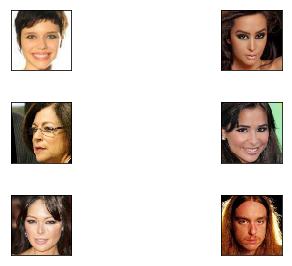

In [8]:
for batch,in data_loader:
    plot_batch((batch.data.cpu().numpy() + 1)/2, limit=6)
    break

[[ 0.00444976  0.01196606  0.00045819 ... -0.00600536  0.01792264
  -0.01824016]]


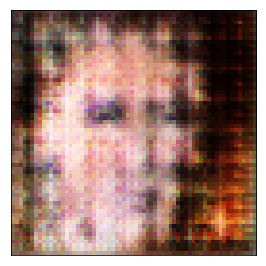

In [13]:
Z, = noise_sampler.sample()
G_sample = generator(Z)
sample = G_sample.data.cpu().numpy()
print(discriminator.layer4.weight.cpu().detach().numpy())
plot_batch((G_sample.data.cpu().numpy() + 1) / 2)

In [14]:
w = generator.layer3[0].weight.data.cpu().numpy()
print(w)

[[[[ 4.04176116e-03  7.26538897e-03 -7.77943619e-03 -1.07896386e-03
    -1.07057979e-02]
   [ 5.76428557e-03  1.28504261e-02 -1.25265764e-02  6.84098620e-03
    -4.18687845e-03]
   [-1.25865722e-02 -8.25712644e-03 -8.04001745e-03  9.13835969e-03
    -6.61331043e-03]
   [ 2.21267948e-03  4.35236562e-03  5.09140035e-03  7.40093505e-03
    -5.41819772e-03]
   [ 6.38022320e-03 -4.15017083e-03 -3.10037145e-03 -1.15697330e-03
    -9.34994221e-03]]

  [[ 7.54398294e-03  1.17953951e-02 -5.90066938e-03 -1.11039151e-02
    -4.67565376e-04]
   [-7.97368679e-03 -1.34514477e-02 -8.16606637e-03  6.62489003e-03
    -2.19401694e-03]
   [ 3.76704568e-03  2.02958542e-03 -6.53423881e-03  1.31645715e-02
    -1.14126131e-03]
   [-5.21397078e-03 -3.33480217e-04 -4.31926397e-04 -1.06432168e-02
     7.75517290e-03]
   [-1.41967237e-02 -1.36144757e-02 -9.79643781e-03  4.11627302e-03
    -7.57303834e-03]]

  [[-1.03103798e-02 -1.94751064e-03  1.01991314e-02  2.15169368e-03
     5.68029180e-04]
   [-3.20522487e-

In [17]:
for X, in data_loader:
    Z, = noise_sampler.sample_batch(data_loader.batch_size)
    G_sample = generator(Z)
    D_real, D_logit_real = discriminator(X)
    D_fake, D_logit_fake = discriminator(G_sample)
    print('D_real', D_real,'\n', 'D_fake', D_fake)
    print('D_logit_real', D_logit_real, '\n', 'D_logit_fake', D_logit_fake)
    break
    

D_real tensor([[ 0.5317],
        [ 0.3298],
        [ 0.4393],
        [ 0.4852],
        [ 0.4829],
        [ 0.5375],
        [ 0.4939],
        [ 0.4525],
        [ 0.4627],
        [ 0.5457],
        [ 0.4524],
        [ 0.3958],
        [ 0.3902],
        [ 0.3994],
        [ 0.4827],
        [ 0.3250],
        [ 0.4353],
        [ 0.5277],
        [ 0.4572],
        [ 0.3576],
        [ 0.4880],
        [ 0.4080],
        [ 0.4290],
        [ 0.4798],
        [ 0.3847],
        [ 0.4519],
        [ 0.4535],
        [ 0.4468],
        [ 0.4518],
        [ 0.3625],
        [ 0.4168],
        [ 0.3235],
        [ 0.4875],
        [ 0.4584],
        [ 0.4125],
        [ 0.3559],
        [ 0.5042],
        [ 0.3383],
        [ 0.4632],
        [ 0.4292],
        [ 0.4455],
        [ 0.4440],
        [ 0.4548],
        [ 0.3584],
        [ 0.4647],
        [ 0.4484],
        [ 0.4782],
        [ 0.4634],
        [ 0.4659],
        [ 0.4227],
        [ 0.4350],
        [ 0.4397],
     